# Baseline Evaluation

This notebook evaluates baseline retrieval methods (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets.

## How to Run

1. Press "Run All" to execute all cells
2. All required DUMMY files will be created automatically if missing
3. Results will be saved to `output/eval/metric/baseline/`
4. Plots will be saved to `output/eval/plot/baseline/`


In [2]:
# Setup: imports and path configuration
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add src to path - handle notebook location
current = Path.cwd()
if current.name == 'eval' and current.parent.name == 'runner':
    project_root = current.parent.parent
else:
    project_root = current
sys.path.insert(0, str(project_root / 'src'))

from eval import (
    compute_metrics_from_files,
    save_metrics_to_csv,
    load_run_file,
    load_qrels_file,
    compute_per_query_metric,
    compare_runs
)
from eval.utils import (
    ensure_directory,
    create_dummy_run_file,
    create_dummy_qrels_file,
    create_dummy_vocab_file,
    find_top_delta_queries,
    create_summary_table
)

print("Setup complete!")


Setup complete!


## Ensure DUMMY Files Exist

Create dummy files if real data is missing.


In [3]:
# Define paths
datasets = ['trec_covid', 'climate_fever']
retrieval_methods = ['bm25', 'tf_idf']
output_base = project_root / 'output'

# Create directory structure
ensure_directory(output_base / 'ingest')
ensure_directory(output_base / 'retrieval' / 'baseline')
ensure_directory(output_base / 'eval' / 'metric' / 'baseline')
ensure_directory(output_base / 'eval' / 'plot')
ensure_directory(output_base / 'eval' / 'slice')

# Create dummy files if missing
for dataset in datasets:
    ingest_dir = output_base / 'ingest'
    
    # Qrels
    qrels_path = ingest_dir / dataset / f'qrels.csv'
    if not qrels_path.exists():
        create_dummy_qrels_file(str(qrels_path), num_queries=10, num_relevant_per_query=5)
        print(f"Created dummy qrels: {qrels_path}")
    
    # Vocab
    vocab_path = ingest_dir / dataset / f'vocab_top50k.txt'
    if not vocab_path.exists():
        create_dummy_vocab_file(str(vocab_path), num_tokens=50000)
        print(f"Created dummy vocab: {vocab_path}")
    
    # Run files for each retrieval method
    for retrieval in retrieval_methods:
        run_path = output_base / 'retrieval' / 'baseline' / f'run_{retrieval}_{dataset}_DUMMY.csv'
        if not run_path.exists():
            create_dummy_run_file(str(run_path), num_queries=10, num_docs_per_query=100)
            print(f"Created dummy run: {run_path}")

print("DUMMY files check complete!")


DUMMY files check complete!


## Compute Metrics for All 4 Combos

Compute nDCG@10, MAP, Recall@100, MRR for:
- BM25 × TREC-COVID
- BM25 × Climate-Fever  
- TF-IDF × TREC-COVID
- TF-IDF × Climate-Fever


In [4]:
# Compute metrics for all combinations
all_metrics = {}

for dataset in datasets:
    qrels_path = output_base / 'ingest' / dataset / 'qrels.csv'
    
    for retrieval in retrieval_methods:
        run_path = output_base / 'retrieval' / 'baseline' / f'run_{retrieval}_{dataset}_DUMMY.csv'
        metric_path = output_base / 'eval' / 'metric' / 'baseline' / f'metric_{retrieval}_{dataset}_DUMMY.csv'
        
        # Compute and save metrics
        metrics = compute_metrics_from_files(str(run_path), str(qrels_path), k=10)
        save_metrics_to_csv(
            metrics,
            str(metric_path),
            dataset=dataset,
            method='baseline',
            retrieval=retrieval
        )
        
        all_metrics[(dataset, 'baseline', retrieval)] = metrics
        print(f"{retrieval} × {dataset}: nDCG@10={metrics['ndcg@10']:.4f}, MAP={metrics['map']:.4f}")

print("\nMetrics computation complete!")


bm25 × trec_covid: nDCG@10=1.0000, MAP=1.0000
tf_idf × trec_covid: nDCG@10=1.0000, MAP=1.0000
bm25 × climate_fever: nDCG@10=1.0000, MAP=1.0000
tf_idf × climate_fever: nDCG@10=1.0000, MAP=1.0000

Metrics computation complete!


## Summary Table


In [5]:
# Create and display summary table
summary_df = create_summary_table(all_metrics)
summary_path = output_base / 'eval' / 'metric' / 'baseline' / 'summary_DUMMY.csv'
summary_df.to_csv(summary_path, index=False)

print("Summary Metrics Table:")
print(summary_df.to_string(index=False))
print(f"\nSaved to: {summary_path}")


Summary Metrics Table:
      dataset   method retrieval  ndcg@10  map  recall@100  mrr
   trec_covid baseline      bm25      1.0  1.0         1.0  1.0
   trec_covid baseline    tf_idf      1.0  1.0         1.0  1.0
climate_fever baseline      bm25      1.0  1.0         1.0  1.0
climate_fever baseline    tf_idf      1.0  1.0         1.0  1.0

Saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\metric\baseline\summary_DUMMY.csv


## Plot nDCG@10 Comparison


Plot saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\plot\baseline_ndcg_DUMMY.png


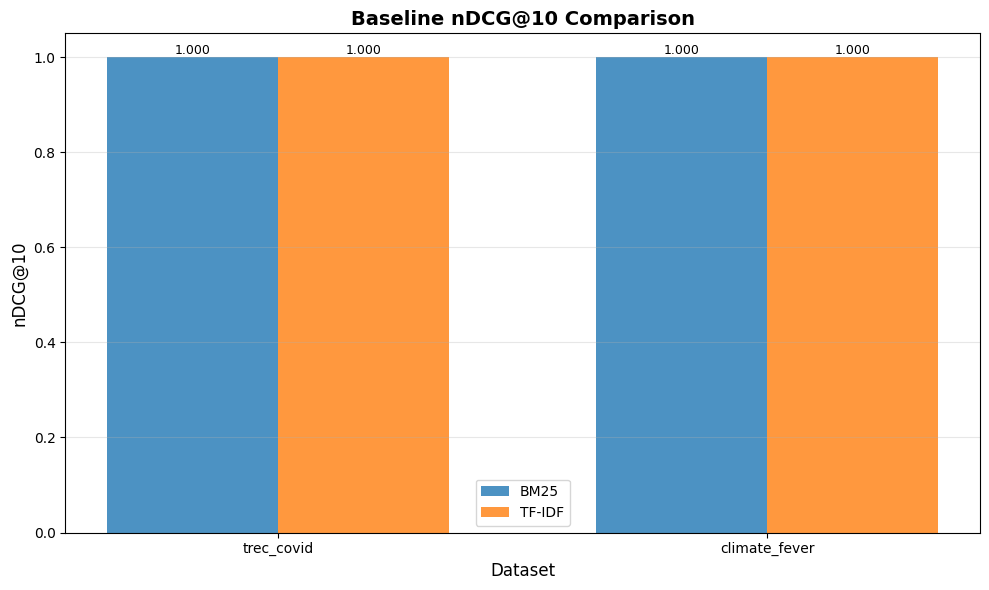

In [6]:
# Plot nDCG@10 comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(datasets))
width = 0.35

bm25_scores = [all_metrics[(d, 'baseline', 'bm25')]['ndcg@10'] for d in datasets]
tfidf_scores = [all_metrics[(d, 'baseline', 'tf_idf')]['ndcg@10'] for d in datasets]

bars1 = ax.bar(x - width/2, bm25_scores, width, label='BM25', alpha=0.8)
bars2 = ax.bar(x + width/2, tfidf_scores, width, label='TF-IDF', alpha=0.8)

ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('nDCG@10', fontsize=12)
ax.set_title('Baseline nDCG@10 Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save plot
plot_path = output_base / 'eval' / 'plot' / 'baseline_ndcg_DUMMY.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")
plt.show()


## Robustness Analysis: Compute Query Slices


In [7]:
# Compute query slices for each dataset
from eval.robustness_slices import compute_query_slices, load_vocabulary

for dataset in datasets:
    run_path = output_base / 'retrieval' / 'baseline' / f'run_bm25_{dataset}_DUMMY.csv'
    vocab_path = output_base / 'ingest' / dataset / 'vocab_top50k.txt'
    slices_path = output_base / 'eval' / 'slice' / f'{dataset}_DUMMY.csv'
    
    # Load vocabulary
    vocab = load_vocabulary(str(vocab_path), top_n=50000)
    
    # Create dummy queries from run file
    run = load_run_file(str(run_path))
    queries = {qid: qid for qid in run.keys()}  # Use qid as query text for dummy
    
    # Compute slices
    slices = compute_query_slices(
        queries,
        str(run_path),
        vocab=vocab,
        output_file=str(slices_path)
    )
    
    familiar = sum(1 for s in slices.values() if s['label'] == 'familiar')
    unfamiliar = len(slices) - familiar
    
    print(f"{dataset}: {familiar} familiar, {unfamiliar} unfamiliar queries")
    print(f"Slices saved to: {slices_path}")

print("\nRobustness analysis complete!")


trec_covid: 0 familiar, 10 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\slice\trec_covid_DUMMY.csv
climate_fever: 0 familiar, 10 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\slice\climate_fever_DUMMY.csv

Robustness analysis complete!
